We benchmark against adversary with $\epsilon=2$.

Natural model from https://github.com/aaron-xichen/pytorch-playground

Robust model from https://github.com/jeromerony/fast_adversarial

In [1]:
!wget -q -O mnist/models/robust.pth https://www.dropbox.com/s/9onr3jfsuc3b4dh/mnist.pth

### Load libraries

In [2]:
import dataclasses
from typing import Dict, List, Optional, Tuple, Union
import warnings

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import ProjectedGradientDescent

import torch
import torch.nn as nn

[torch.cuda.get_device_name(a)
    for a in range(torch.cuda.device_count())]

['NVIDIA GeForce RTX 3080']

In [4]:
import sys
sys.path.append("../..")

import mnist.nat_model
import mnist.rob_model

from adversarial_ntks import dataset

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Load data

In [5]:
MNIST_TEST = dataset.get_np_data(
    name="mnist", split="test", agg_labels=((0,1,2,3,4),(5,6,7,8,9))
)
MNIST_TEST = MNIST_TEST.replace_xs(MNIST_TEST.xs.astype(np.float32))

print(MNIST_TEST.xs.shape, MNIST_TEST.xs.min(), MNIST_TEST.xs.max())

(10000, 784) 0.0 1.0


[0 0 0 1 1 1 0 1 0 0]


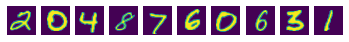

In [6]:
dataset.plot_images(MNIST_TEST, channels=1)

### Load models

In [7]:
class BinModel(nn.Module):
    def __init__(self, model10: nn.Module):
        super().__init__()
        self.model10 = model10
        
    def forward(self, xs):
        out10 = self.model10.forward(xs)
        out2by5 = out10.view(-1, 2, 5)
        out2 = torch.max(out2by5, dim=-1).values
        return out2

In [8]:
base_nat_model = mnist.nat_model.get_model(pretrained=True)
nat_model = BinModel(base_nat_model)
nat_model.eval();
nat_model

BinModel(
  (model10): MLP(
    (model): Sequential(
      (fc1): Linear(in_features=784, out_features=256, bias=True)
      (relu1): ReLU()
      (drop1): Dropout(p=0.2, inplace=False)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (relu2): ReLU()
      (drop2): Dropout(p=0.2, inplace=False)
      (out): Linear(in_features=256, out_features=10, bias=True)
    )
  )
)

In [9]:
base_rob_model = mnist.rob_model.get_model(model_path="mnist/models/robust.pth")
rob_model = BinModel(base_rob_model)
rob_model.eval();
rob_model

BinModel(
  (model10): SmallCNN(
    (feature_extractor): Sequential(
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (relu2): ReLU(inplace=True)
      (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (relu3): ReLU(inplace=True)
      (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (relu4): ReLU(inplace=True)
      (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (classifier): Sequential(
      (fc1): Linear(in_features=1024, out_features=200, bias=True)
      (relu1): ReLU(inplace=True)
      (drop): Dropout(p=0.5, inplace=False)
      (fc2): Linear(in_features=200, out_features=200, bias=True)
      (relu2): ReLU(inplace=True)
      (fc3): Linear(in_features=200, out_features=10, bias=True)
   

### Experiment setup

In [10]:
def run_experiment(
    bin_model: BinModel,
    ds: dataset.Dataset,
    attack_norm: Union[float, int],
    attack_eps: float,
    attack_eps_step: float,
    attack_iters: int,
    batch_size: int,
    seed: int = 42
):
    """
    ART code derived from
    1. https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_retraining.ipynb
    2. https://github.com/Trusted-AI/adversarial-robustness-toolbox/issues/238
    3. https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/examples/get_started_pytorch.py
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    bin_model.eval()
    
    art_model = PyTorchClassifier(
        model=bin_model,
        input_shape=ds.xs[0].shape,
        nb_classes=ds.num_classes,
        clip_values=(0, 1),
        loss=nn.CrossEntropyLoss(),
    )
    art_pgd_attack = ProjectedGradientDescent(
        art_model,
        norm=attack_norm,
        eps=attack_eps,
        eps_step=attack_eps_step,
        max_iter=attack_iters,
        batch_size=batch_size,
        verbose=True,
    )
    
    preds_nat = art_model.predict(x=ds.xs)
    acc_nat = np.mean(np.argmax(preds_nat, axis=-1) == ds.ys)
    print(f"Nat acc: {acc_nat:.4f}")
    
    xs_pgd = art_pgd_attack.generate(x=ds.xs, y=ds.ys)
    preds_pgd = art_model.predict(x=xs_pgd)
    acc_pgd = np.mean(np.argmax(preds_pgd, axis=-1) == ds.ys)
    print(f"PGD acc: {acc_pgd:.4f}")
    
    return dict(
        acc_nat=acc_nat,
        acc_pgd=acc_pgd,
        xs_pgd=xs_pgd,
        preds_pgd=preds_pgd,
    )

# Run experiments

### Natural model

In [23]:
NAT_RES_DICT = run_experiment(
    bin_model=nat_model,
    ds=MNIST_TEST,
    attack_norm=2,
    attack_eps=2.0,
    attack_eps_step=2.0/10,
    attack_iters=20,
    batch_size=512,
    seed=42,
)

Nat acc: 0.9867


PGD - Batches:   0%|          | 0/20 [00:00<?, ?it/s]

PGD acc: 0.0669


Nat data
[0 0 0 1 1 1 0 1 0 0]


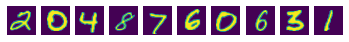

PGD data
[0 0 0 1 1 1 0 1 0 0]


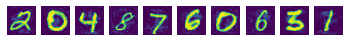

PGD preds
[1 0 1 0 0 0 0 0 1 1]


In [25]:
print("Nat data")
dataset.plot_images(MNIST_TEST, channels=1)

print("PGD data")
dataset.plot_images(
    dataset.Dataset(
        xs=NAT_RES_DICT["xs_pgd"],
        ys=MNIST_TEST.ys,
        one_hot=False,
        num_classes=2,
    ), channels=1
)
print("PGD preds")
print(NAT_RES_DICT["preds_pgd"][:10].argmax(axis=-1))

### Robust model

In [11]:
%%time
ROB_RES_DICT = run_experiment(
    bin_model=rob_model,
    ds=MNIST_TEST.replace_xs(MNIST_TEST.xs.reshape(-1, 1, 28, 28)),
    attack_norm=2,
    attack_eps=2.0,
    attack_eps_step=2.0/10,
    attack_iters=20,
    batch_size=512,
    seed=42,
)

Nat acc: 0.9928


PGD - Batches:   0%|          | 0/20 [00:00<?, ?it/s]

/home/ttw/.miniconda3/envs/adv-ntk/lib/python3.8/site-packages/art/estimators/classification/pytorch.py:670: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/home/ttw/.miniconda3/envs/adv-ntk/lib/python3.8/site-packages/art/estimators/classification/pytorch.py:671: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)


PGD acc: 0.8809
CPU times: user 5.58 s, sys: 1.43 s, total: 7.01 s
Wall time: 12 s


Nat data
[0 0 0 1 1 1 0 1 0 0]


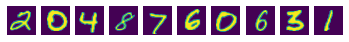

PGD data
[0 0 0 1 1 1 0 1 0 0]


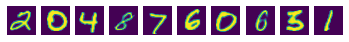

PGD preds
[0 0 0 1 1 1 0 1 1 0]


In [15]:
print("Nat data")
dataset.plot_images(MNIST_TEST, channels=1)

print("PGD data")
dataset.plot_images(
    dataset.Dataset(
        xs=ROB_RES_DICT["xs_pgd"].reshape(-1, 784),
        ys=MNIST_TEST.ys,
        one_hot=False,
        num_classes=2,
    ), channels=1
)
print("PGD preds")
print(ROB_RES_DICT["preds_pgd"][:10].argmax(axis=-1))